In [2]:
import numpy as np
import pandas as pd
import os
from collections import OrderedDict, deque
import matplotlib.pyplot as plt
import time

# Part 1 - Generating Intermediate data 
- a spectrum of depth 50 and price step 1 (used to calcualate spectrum and VWAP) for each timestamp
- log with orders marked as passive or aggresive

In [21]:
class Stakan5():
    def __init__(self, minstep):
        self.ask = OrderedDict()
        self.bid = OrderedDict()
        self.event_log = ""
        self.error_log = ""
        self.system_log = {'ts': [],'side': [], 'type': [], 'vol':[], 'price': [], 'price_norm':[], 'ordno': []}
        self.minstep = minstep
        self.spec = [({'ts':0, 'sa':0, 'lb':0},[],[])]
        self.spec_depth = 50
        self.times = {'aa':0, 'ab':0, 'pa':0, 'pb':0, 'ra':0, 'rb':0, 'sp':0}
        self.c = {'aa':0, 'ab':0, 'pa':0, 'pb':0, 'ra':0, 'rb':0, 'sp':0}
    
    def add_spec(self, ts):
        return
        if (self.spec[-1][0]['ts']  !=  ts and self.get_smallest_ask() is not None and self.get_largest_bid() is not None):
            t=time.time()
            sa = self.get_smallest_ask()
            lb = self.get_largest_bid()
            ask_spec = []
            for i in range(self.spec_depth):
                p = sa + self.minstep*i
                if (p in self.ask):
                    ask_spec.append(sum(e[1] for e in self.ask[p]))
                else: ask_spec.append(0)
            
            bid_spec = []
            for i in range(self.spec_depth):
                p = lb - self.minstep*i
                if (p in self.bid):
                    bid_spec.append(sum(e[1] for e in self.bid[p]))
                else: bid_spec.append(0)
            
            self.spec.append(({'ts': ts, 'sa': sa, 'lb':lb}, ask_spec, bid_spec[::-1]))
            self.times['sp'] += time.time()-t
            self.c['sp'] += 1
    
    def sys_log(self, side, type_, price, ts, vol, ordno):
        self.system_log['side'].append(side)
        self.system_log['type'].append(type_)
        self.system_log['price'].append(price/100000)
        self.system_log['ts'].append(ts)
        self.system_log['ordno'].append(ordno)
        self.system_log['vol'].append(vol)
        
        mid = (self.get_smallest_ask()+self.get_largest_bid())/2
        self.system_log['price_norm'].append(abs(mid-price)/self.minstep)
        
    
    def get_smallest_ask(self):
        for price in self.ask:
            if self.ask[price]:
                return price
        return float("inf")
    
    def get_largest_bid(self):
        for price in self.bid:
            if self.bid[price]:
                return price
        return -float("inf")
    
    def sort(self, o, reverse=False):
        return OrderedDict(sorted(o.items(), reverse=reverse, key=lambda x:x[0]))
    
    def log(self, text):
        return
        self.event_log += text + '\n'
    
    def errlog(self, text):
        self.error_log += text + '\n'
        #self.event_log += text + '\n'
                           
    def add_ask(self, orderno, price, volume, ts):
        if (volume == 0): return
        t=time.time()
        
        
        if (self.get_largest_bid() >= price):
            # if it is an aggressve ask:
            #pass
            self.log(f'aggressive ask {orderno}')
            
            l_bid = self.get_largest_bid()
            l_bid_num, l_bid_volume = self.bid[l_bid].popleft()
            if (l_bid_volume <= volume):
                # if bid is too small we consume it and go on
                self.log(f' new ask {orderno} is partially sat')
                self.log(f'bid {l_bid_num} is sat')
                
                self.sys_log(side='a', type_='agro', price=price, ts=ts, vol=l_bid_volume, ordno = orderno)
                self.add_ask(orderno, price, volume - l_bid_volume, ts)
            else:
                # if bid is too big we change it and return to the begining of queque
                
                self.sys_log(side='a', type_='agro', price=price, ts=ts, vol=volume, ordno = orderno)
                
                self.log(f'new ask {orderno} is sat')
                self.log(f'bid {l_bid_num} is partially sat')
                self.bid[l_bid].appendleft((l_bid_num, l_bid_volume - volume)) 
            self.times['aa']+=time.time()-t
            self.c['aa']+=1
        else:
            # if it is a passive ask
            if (price == 0.0 or price == float('inf')):
                # check if we need to cancel it
                self.log(f'ask {orderno} is IoC and canceled')
            else:
                self.sys_log(side='a', type_='passive', price=price, ts=ts, vol=volume, ordno = orderno)
                if (price not in self.ask):
                    self.log(f'ask {orderno} is added, new price')
                    
                    self.ask[price] = deque(((orderno, volume),))
                    #sort asks by price in increasing order
                    self.ask = self.sort(self.ask)
                    
                else:
                    self.log(f'ask {orderno} is added')
                    self.ask[price].append((orderno, volume))
                    
            self.times['pa']+=time.time()-t
            self.c['pa']+=1
        self.add_spec(ts)
    
    def add_bid(self, orderno, price, volume, ts):
        if (volume == 0): return
        t = time.time()
                       
        if (self.get_smallest_ask() <= price):
            # if it is an aggressve bid:
            self.log(f'aggressive bid {orderno}')
            
            
            s_ask = self.get_smallest_ask()
            s_ask_num, s_ask_volume = self.ask[s_ask].popleft()
            if (s_ask_volume <= volume):
                # if ask is too small we consume it and go on
                self.log(f' new bid {orderno} is partially sat')
                self.log(f'ask {s_ask_num} is sat')
                
                self.sys_log(side='b', type_='agro', price=price, ts=ts, vol=s_ask_volume, ordno = orderno)
                self.add_bid(orderno, price, volume - s_ask_volume, ts)
            else:
                # if ask is too big we change it and return to the begining of queque
                
                self.sys_log(side='b', type_='agro', price=price, ts=ts, vol=volume, ordno = orderno)
                
                self.log(f'new bid {orderno} is sat')
                self.log(f'ask {s_ask_num} is partially sat')
                self.ask[s_ask].appendleft((s_ask_num, s_ask_volume - volume))
            self.times['ab']+=time.time()-t
            self.c['ab']+=1
        else:
            # if it is a passive bid
            if (price == 0.0 or price == float('inf')):
                # check if we need to cancel it
                self.log(f'bid {orderno} is IoC and canceled')
            else:
                self.sys_log(side='b', type_='passive', price=price, ts=ts, vol=volume, ordno = orderno)
                if (price not in self.bid):
                    self.log(f'bid {orderno} is added, new price')
                    self.bid[price] = deque(((orderno, volume),))
                    #sort bids by price in decreasing order
                    self.bid = self.sort(self.bid, reverse=True)
                else:
                    self.log(f'bid {orderno} is added')
                    self.bid[price].append((orderno, volume))
            self.times['pb']+=time.time()-t
            self.c['pb']+=1
        self.add_spec(ts)
    
    def remove_ask(self, orderno, price, volume, ts):
        t = time.time()
        self.log(f'ask {orderno} removing')
        if price not in self.ask:
            self.errlog(f'removing ask with non-existing price {(orderno, price, volume)}')
            return
        match = None
        for i,e in enumerate(self.ask[price]):
            if (e[0] == orderno):
                match = i
        if match is not None:
            assert self.ask[price][match][0] == orderno
            if (self.ask[price][match][1] != volume): 
                self.errlog(f'wrong volume on removing ask {(orderno, price, volume)}')
            del self.ask[price][match]
        else:
            self.errlog(f'removing sat ask {(orderno, price, volume)}')
        self.times['ra']+=time.time()-t
        self.c['ra']+=1
        self.add_spec(ts)
    
    def remove_bid(self, orderno, price, volume, ts):
        t = time.time()
        self.log(f'bid {orderno} removing')
        if price not in self.bid:
            self.errlog(f'removing bid with non-existing price {(orderno, price, volume)}')
            return
        match = None
        for i,e in enumerate(self.bid[price]):
            if (e[0] == orderno):
                match = i
        if match is not None:
            assert self.bid[price][match][0] == orderno
            if (self.bid[price][match][1] != volume): 
                self.errlog(f'wrong volume on removing bid {(orderno, price, volume)}')
            del self.bid[price][match]
        else:
            self.errlog(f'removing sat bid {(orderno, price, volume)}')
        self.times['rb']+=time.time()-t
        self.c['rb']+=1
        self.add_spec(ts)
    
    def to_df(self):
        buysell = []
        price = []
        orderno = []
        volume = []
        for p in self.bid:
            for no, vol in self.bid[p]:
                buysell.append('B')
                price.append(p)
                orderno.append(no)
                volume.append(vol)
        
        buysell = buysell[::-1]
        price = price[::-1]
        orderno = orderno[::-1]
        volume = volume[::-1]
        for p in self.ask:
            for no, vol in self.ask[p]:
                buysell.append('S')
                price.append(p)
                orderno.append(no)
                volume.append(vol)
            
        return pd.DataFrame(data={'orderno':orderno, 'buysell':buysell, 'price':price, 'volume':volume})
    
    def clean(self):
        ac = 0
        #print('cleaning')
        for e in list(self.ask):
            if (not self.ask[e]):
                del self.ask[e]
                ac+=1
        #print('ac= ',ac)
        
        bc = 0
        for e in list(self.bid):
            if (not self.bid[e]):
                del self.bid[e]
                bc += 1
                
        #print('bc= ',bc)
        print('# of px ', len(self.ask), len(self.bid))
        print('total ', sum(len(self.ask[e]) for e in self.ask), sum(len(self.bid[e]) for e in self.bid))
    
    def get_log(self):
        return pd.DataFrame(data = self.system_log)
    
    def get_spec(self):
      # self.spec = [({'ts':0, 'sa':0, 'lb':0},[ask],[bid])]
      data = {}
      ts = [e[0]['ts'] for e in self.spec]
      sa = [e[0]['sa']/100000 for e in self.spec]
      lb = [e[0]['lb']/100000 for e in self.spec]
      a = {'ask'+str(i): [e[1][i] if len(e[1])>i else 0 for e in self.spec] for i in range(self.spec_depth)}
      b = {'bid'+str(i): [e[2][self.spec_depth-1-i] if len(e[2])>self.spec_depth-1-i else 0 for e in self.spec] for i in range(self.spec_depth)}
      return pd.DataFrame(data = {'ts':ts, 'sa':sa, 'lb':lb, **b, **a})

In [26]:
order_book = None
arr = []
arr2 = []
def solve(path_in, path_out,
          instruments = ['USD000000TOD', 'USD000UTSTOM', 'EUR_RUB__TOD', 'EUR_RUB__TOM', 'EURUSD000TOD', 'EURUSD000TOM'], save=False):
    global arr, order_book, arr2
    arr = []
    arr2 = []
    
    o=pd.read_csv(path_in)
    o['ACTION'].replace({0:3}, inplace=True)
    o = o.sort_values(by=['TIME','ACTION'])
    o['PRICE'] = round(o['PRICE']*100000).astype(int)

    #instruments = ['USD000000TOD', 'USD000UTSTOM', 'EUR_RUB__TOD', 'EUR_RUB__TOM']
    #instruments = ['USD000000TOD', 'USD000UTSTOM', 'EUR_RUB__TOD', 'EUR_RUB__TOM', 'EURUSD000TOD', 'EURUSD000TOM']
    #instruments = ['USD000000TOD', 'USD000UTSTOM', 'EUR_RUB__TOD', 'EUR_RUB__TOM', 'EURUSD000TOD', 'EURUSD000TOM']
    
    minstep = {'USD000000TOD': 250, 'USD000UTSTOM': 250, 'EUR_RUB__TOD': 250, 'EUR_RUB__TOM': 250, 'EURUSD000TOD':1, 'EURUSD000TOM':1}
    for instrument in instruments:
        print('starting', instrument)
        f1_e=os.path.exists(os.path.join(path_out, instrument+'_syslog'+'.csv'))
        f2_e=os.path.exists(os.path.join(path_out, instrument+'_spec'+'.csv'))
        if (f1_e and f2_e):
            print('Already exists!')
            continue
            
        order_book = Stakan5(minstep[instrument])
        ob = order_book
        percent = 0.0
        order_log = o[o['SECCODE'] == instrument]
        l = len(order_log)
        print('len is', l)
        if l==0: continue 
        i = 0
        t = time.time()
        times = []
        for _, order in order_log.iterrows():
            try:
                    
                if (order_book.ask != order_book.sort(order_book.ask) and save):
                    print(order_book.ask)
                    raise Exception
                
                if (i/l >= percent):
                    print(int((i/l)*100),'%')
                    percent += 0.1
                    order_book.clean()
                    times.append(time.time() - t)
                i+=1

                action = order.ACTION
                buysell = order.BUYSELL
                args = (order.ORDERNO, order.PRICE, order.VOLUME, order.TIME)
                if (action == 1 and buysell == 'B'):
                    order_book.add_bid(*args)
                if (action == 1 and buysell == 'S'):
                    order_book.add_ask(*args)
                if (action == 3 and buysell == 'B'):
                    order_book.remove_bid(*args)
                if (action == 3 and buysell == 'S'):
                    order_book.remove_ask(*args)
                #if (action == 2 and buysell == 'B'):
                #    order_book.match_bid(*args)
                #if (action == 2 and buysell == 'S'):
                #    order_book.match_ask(*args)
                
                if (action == 1 and
                    order_book.get_smallest_ask() not in [float('inf'),float('-inf')]
                   and order_book.get_largest_bid() not in [float('inf'),float('-inf')]):
                    vall = (order_book.get_smallest_ask()+order_book.get_largest_bid())/2
                    arr.append(vall)
                    if (not arr2 or arr2[-1]!=vall):
                        arr2.append(vall)
                    
            except Exception as e:
                print(path_in, order)
                print(order_book.event_log.split('\n')[-5:])
                raise e

        print(int((i/l)*100),'%')
        
        print('t= ',time.time() - t)
        times.append(time.time() - t)

        plt.plot(times)
        plt.show()

        print('10000*avg')
        for e in order_book.times:
            if (order_book.c[e]!=0):
                print(e, 10000*order_book.times[e]/order_book.c[e])

        print('total')
        for e in order_book.times:
            print(e, order_book.times[e])
            
        if (save):
            if not os.path.exists(path_out):
                os.makedirs(path_out)
            
            df = order_book.to_df()
            df.to_csv(os.path.join(path_out, instrument+'.csv'), index=False)

            order_book.get_spec().to_csv(os.path.join(path_out, instrument+'_spec'+'.csv'), index=False)
            log_folder=os.path.join(path_out, instrument+'_logs'+'/') 
            
            if not os.path.exists(log_folder):
                os.makedirs(log_folder)

            with open(os.path.join(log_folder, 'error_log.txt'), 'w') as file:
                file.write(order_book.error_log)

            ob.get_log().to_csv(os.path.join(path_out, instrument+'_syslog'+'.csv'), index=False)

In [ ]:
path_in = f'../MOEX-FX/2018-03/OrderLog20180301.txt'
path_out = f''
solve(path_in, path_out, ['USD000000TOD'], save=False)

days = ['2018-03','2018-04', '2018-05']
for day in days:
    l = [e for e in os.listdir(f'../MOEX-FX/{day}/') if e[:3]=='Ord']
    for name in l:
        if True:
            print('start', name)
            path_in = f'../MOEX-FX/{day}/{name}'
            path_out = f'../out2/{day}/{name[:-4]}/'
            print(path_in, path_out)
            df = solve(path_in, path_out)

## Intermediate data:

In [4]:
o= pd.read_csv('../out2/2018-03/OrderLog20180301/USD000000TOD_spec.csv')
o[1000:1020]

,ts,sa,lb,bid0,bid1,bid2,bid3,bid4,bid5,bid6,...,ask40,ask41,ask42,ask43,ask44,ask45,ask46,ask47,ask48,ask49
1000,100015009883,56.43,56.42,20000,0,0,150000,100000,150000,150000,...,2000,0,0,0,1000,0,0,0,8000,0
1001,100015010541,56.43,56.42,70000,0,0,150000,100000,150000,150000,...,2000,0,0,0,1000,0,0,0,8000,0
1002,100015018275,56.43,56.42,70000,0,0,150000,100000,453000,150000,...,2000,0,0,0,1000,0,0,0,8000,0
1003,100015018287,56.43,56.42,70000,0,50000,150000,100000,453000,150000,...,2000,0,0,0,1000,0,0,0,8000,0
1004,100015018310,56.43,56.42,70000,50000,50000,150000,100000,403000,150000,...,2000,0,0,0,1000,0,0,0,8000,0
1005,100015018721,56.43,56.42,70000,50000,50000,150000,50000,503000,150000,...,2000,0,0,0,1000,0,0,0,8000,0
1006,100015018733,56.43,56.42,70000,50000,50000,150000,50000,503000,150000,...,2000,0,0,0,1000,0,0,0,8000,0
1007,100015018743,56.43,56.42,70000,50000,50000,150000,50000,503000,250000,...,2000,0,0,0,1000,0,0,0,8000,0
1008,100015019166,56.43,56.42,70000,50000,50000,150000,50000,503000,250000,...,2000,0,0,0,1000,0,0,0,8000,0
1009,100015019273,56.43,56.42,70000,50000,50000,150000,50000,503000,100000,...,2000,0,0,0,1000,0,0,0,8000,0


In [6]:
o= pd.read_csv('../out2/2018-03/OrderLog20180301/USD000000TOD_syslog.csv')
o[1000:1020]

,ts,side,type,vol,price,price_norm,ordno
1000,100018805115,a,passive,1000,56.6750,103.0,3552
1001,100018815515,a,passive,1000000,56.4550,15.0,3554
1002,100018866634,a,passive,1000000,56.4750,23.0,3562
1003,100018875214,a,passive,1000,56.6750,103.0,3564
1004,100018891502,a,passive,50000,56.4450,11.0,3568
1005,100018891511,a,passive,50000,56.4500,13.0,3569
1006,100018891515,a,passive,50000,56.4500,13.0,3570
1007,100018891523,a,passive,50000,56.4475,12.0,3571
1008,100018893901,b,passive,50000,56.4025,6.0,3574
1009,100018893911,b,passive,50000,56.4000,7.0,3576


## Part 1.1 computing autocorrelation

starting USD000UTSTOM
len is 1574023
0 %
# of px  0 0
total  0 0
10 %
# of px  248 246
total  561 608
20 %
# of px  242 295
total  562 727
30 %
# of px  236 333
total  548 823
40 %
# of px  238 366
total  560 975
50 %
# of px  237 378
total  613 1009
60 %
# of px  227 380
total  599 1155
70 %
# of px  287 346
total  744 1041
80 %
# of px  285 370
total  869 1128
90 %
# of px  251 399
total  670 1207
100 %
t=  275.07184076309204


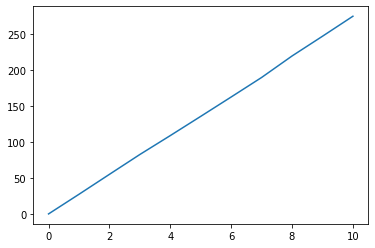

10000*avg
aa 0.5508805618131699
ab 0.5364415736637334
pa 0.12841255825419517
pb 0.1332993807735572
ra 0.03620664281841913
rb 0.03532493168696503
total
aa 1.0613815784454346
ab 1.1154766082763672
pa 4.809319972991943
pb 5.018934965133667
ra 1.313805103302002
rb 1.289914608001709
sp 0


In [28]:
path_in = f'../MOEX-FX/2018-03/OrderLog20180301.txt'
path_out = f''
solve(path_in, path_out, ['USD000UTSTOM'], False)

### It is possible that $x_k = x_{k-1}$

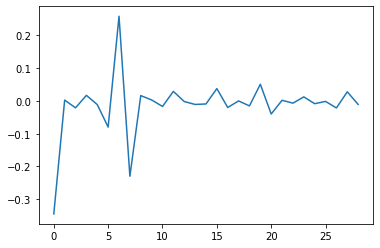

In [29]:
#arr_norm = [e - arr_avg for e in arr]
arr_norm = []
for i in range(len(arr)-1):
    arr_norm.append(arr[i+1] - arr[i])
arr_avg = sum(arr_norm)/len(arr_norm)
arr_norm = [e - arr_avg for e in arr_norm]
auto = []
for k in range(1,30):
    c = np.corrcoef(arr_norm[k:], arr_norm[:-k])
    auto.append(c[0,1])
plt.plot(auto)

###  $x_k \neq x_{k-1}$ always

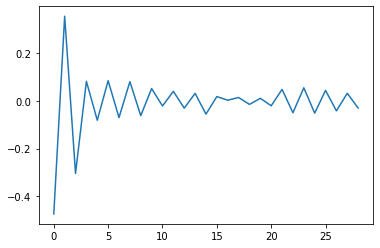

In [30]:
#arr_norm = [e - arr_avg for e in arr]
arr_norm = []
for i in range(len(arr2)-1):
    arr_norm.append(arr2[i+1] - arr2[i])
arr_avg = sum(arr_norm)/len(arr_norm)
arr_norm = [e - arr_avg for e in arr_norm]

auto = []
for k in range(1,30):
    c = np.corrcoef(arr_norm[k:], arr_norm[:-k])
    auto.append(c[0,1])
plt.plot(auto)

# Part 2 Simple statistics

In [7]:
def timefix(t):
    t=str(t-100000000000)
    t='0'*(12-len(t))+t
    h=int(t[0:2])*60*60*(10**6)
    m=int(t[2:4])*60*(10**6)
    s=int(t[4:6])*10**6
    z=int(t[6:9])*10**3
    x=int(t[9:12])*1
    return h+m+s+z+x

def my_ks(data1, data2, n, m):
    data1 = [sum(data1[0:i+1]) for i in range(len(data1))]
    data2 = [sum(data2[0:i+1]) for i in range(len(data2))]
    data1 = [e/data1[-1] for e in data1]
    data2 = [e/data2[-1] for e in data2]
    d = max(abs(a - b) for a,b in zip(data1,data2))
    a = 0.975
    ka = np.sqrt(-1/2*np.log((1-a)/2))
    return d*np.sqrt((n*m)/(n+m)), ka

def shorten(l):
    return [sum(l[i:i+5]) for i in range(0,50,5)]


def task3(df, step=None):
    df['ts']=df['ts'].apply(timefix)
    plt.subplots_adjust(hspace=1,right=2.5,bottom=0.01)
    plt.subplot(1,2,2)
    bid_c = [df['bid'+str(i)].mean() for i in range(50)]
    ask_c = [df['ask'+str(i)].mean() for i in range(50)]
    
    bid_c = shorten(bid_c)
    ask_c = shorten(ask_c)
    
    plt.bar(range(1, len(ask_c) + 1), ask_c, color='green', width=1)
    plt.bar(range(-1, -len(bid_c) - 1, -1), bid_c,color='red', width=1)
    plt.title("avg by count")
    plt.subplot(1,2,1)

    last = None
    bid_t = [0 for _ in range(50)]
    ask_t = [0 for _ in range(50)]
    for _, e in df.iterrows():
        if (last is not None):
            t = e['ts']-last['ts']
            for i in range(50):
                bid_t[i] += last['bid'+str(i)]*t
                ask_t[i] += last['ask'+str(i)]*t
        last = e

    dt = max(df['ts']) - min(df['ts'])
    ask_t = [e/dt for e in ask_t]
    bid_t = [e/dt for e in bid_t]
    
    bid_t = shorten(bid_t)
    ask_t = shorten(ask_t)

    plt.bar(range(1, len(ask_t)+1),ask_t, color='green', width=1)
    plt.bar(range(-1, -len(bid_t)-1, -1), bid_t, color='red', width=1)

    plt.title("avg by time")
    plt.show()
    
    teams_list=['ask count','bid time']
    rows = ['bid count','ask time']
    #temp = lambda a,b:'s=%.3f q=%.3f'%my_ks(a, b, len(df)//2 , len(df)//2)
    temp = lambda a,b:'s=%.3f q=%.3f'%my_ks(a, b, 50 , 50)
    data=[[temp(ask_c, bid_t), temp(bid_c, bid_t)],[temp(ask_c, ask_t),temp(bid_t, ask_t)]]

    row_format ="{:>20}" * (len(teams_list) + 1)
    print(row_format.format("", *teams_list))
    for team, row in zip(rows, data):
            print(row_format.format(team, *row))

    plt.subplots_adjust(hspace=1,right=2.5,bottom=0.01)
    plt.plot(df['ts'], df['sa'], color='green')
    plt.plot(df['ts'], df['lb'], color='red')

    clean = df[(df['sa']!=float('inf')) & (df['lb']!=0.0)]
    s,l = ((clean['sa'] + clean['lb'])/2).quantile([0.05,0.95])
    plt.ylim(bottom=s*0.995)
    plt.ylim(top=l*1.005)
    plt.title('price')
    plt.show()

    plt.subplots_adjust(hspace=1,right=2.5,bottom=0.01)
    plt.plot(df['ts'], df['sa']-df['lb'])
    l = (df['sa']-df['lb']).quantile(0.999)
    plt.ylim(top = l*1.5, bottom=0.0)
    plt.title('bid-ask spread')
    plt.show()

USD000000TOD


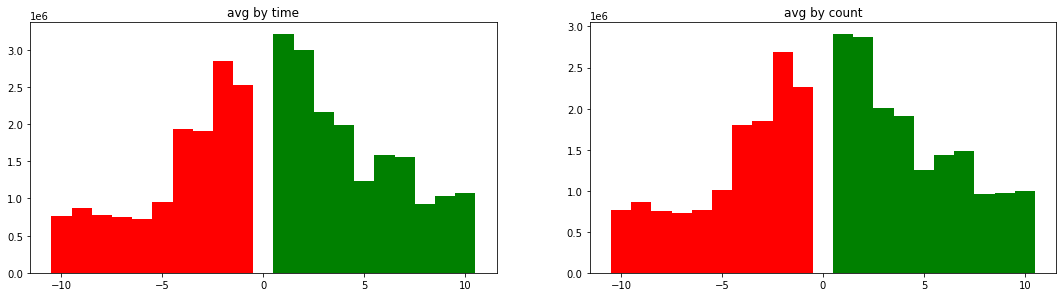

                               ask count            bid time
           bid count     s=0.387 q=1.480     s=0.085 q=1.480
            ask time     s=0.037 q=1.480     s=0.359 q=1.480


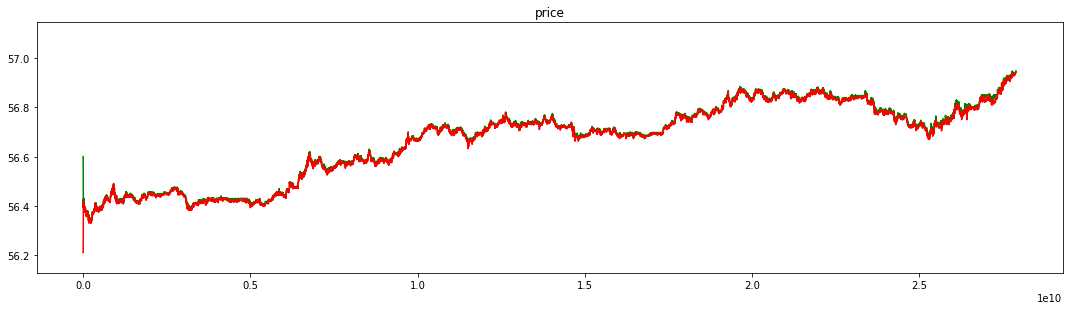

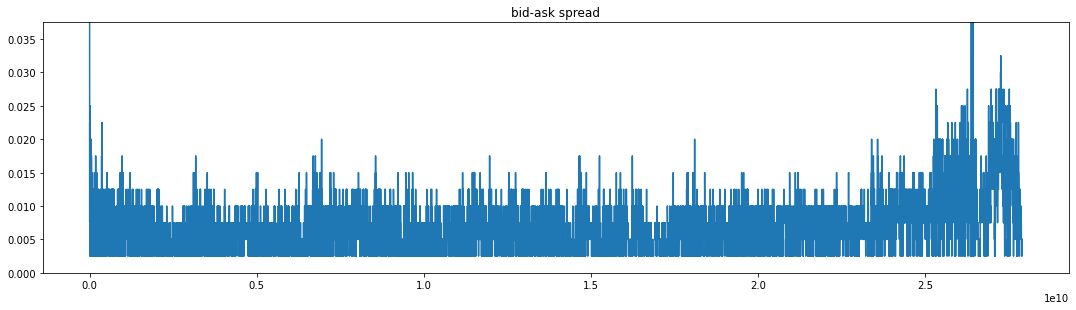

USD000UTSTOM


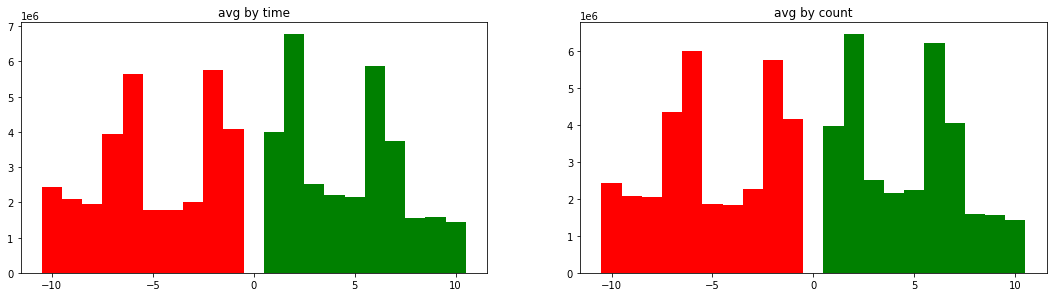

                               ask count            bid time
           bid count     s=0.323 q=1.480     s=0.049 q=1.480
            ask time     s=0.088 q=1.480     s=0.355 q=1.480


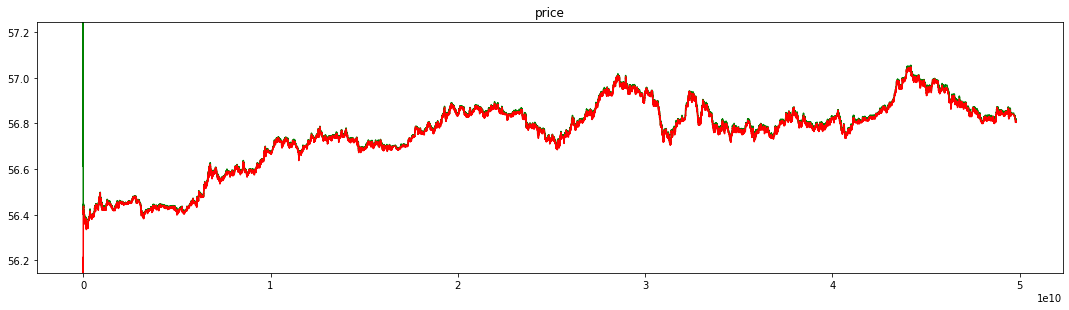

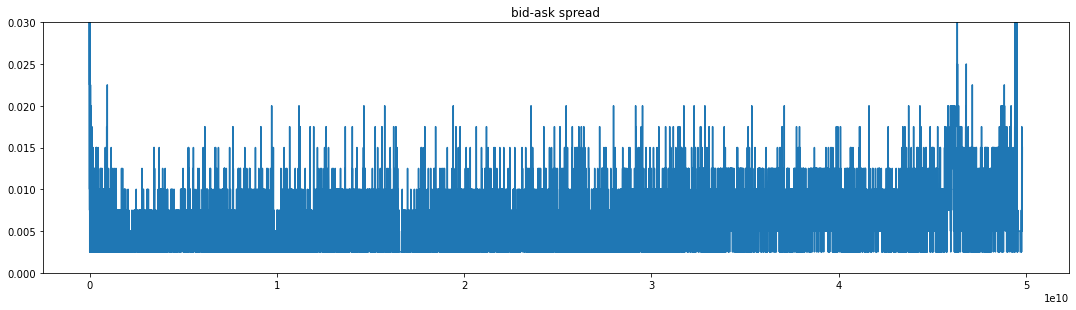

EUR_RUB__TOD


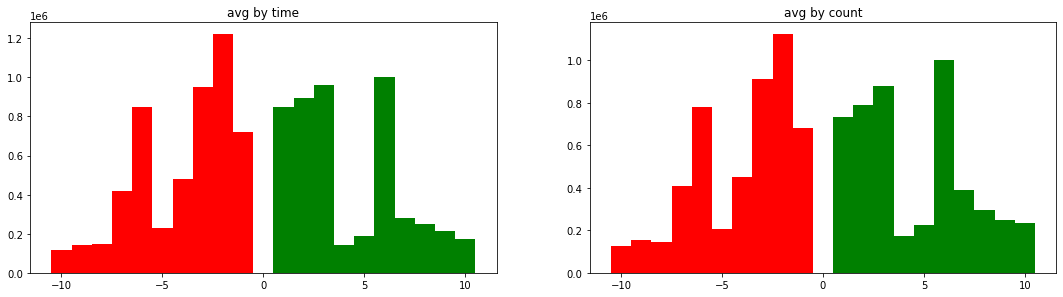

                               ask count            bid time
           bid count     s=0.609 q=1.480     s=0.051 q=1.480
            ask time     s=0.318 q=1.480     s=0.350 q=1.480


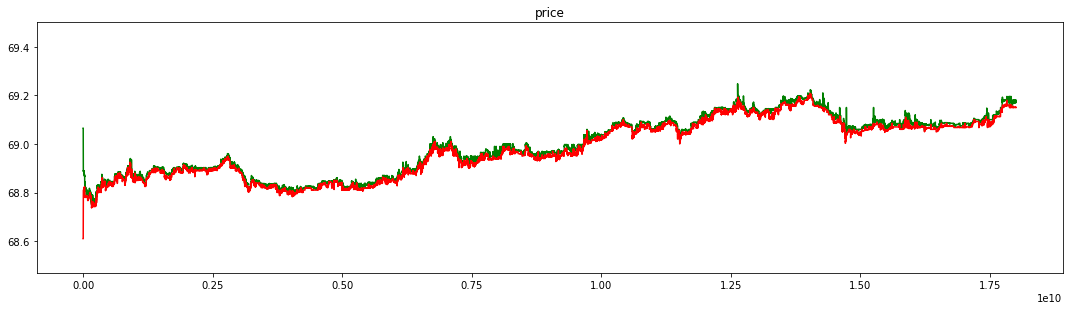

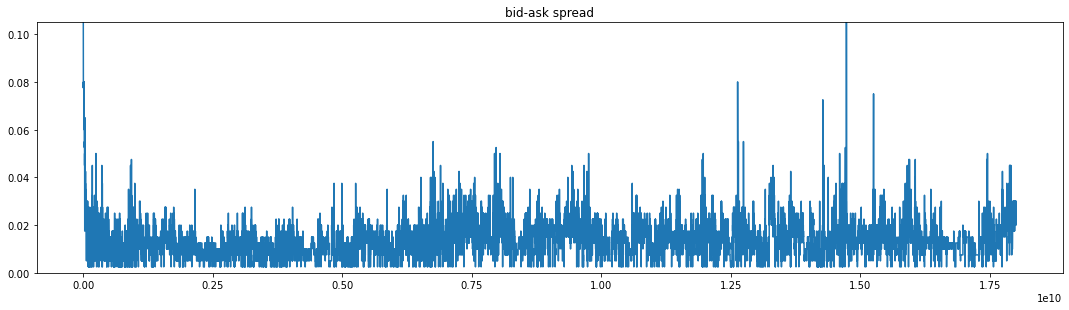

EUR_RUB__TOM


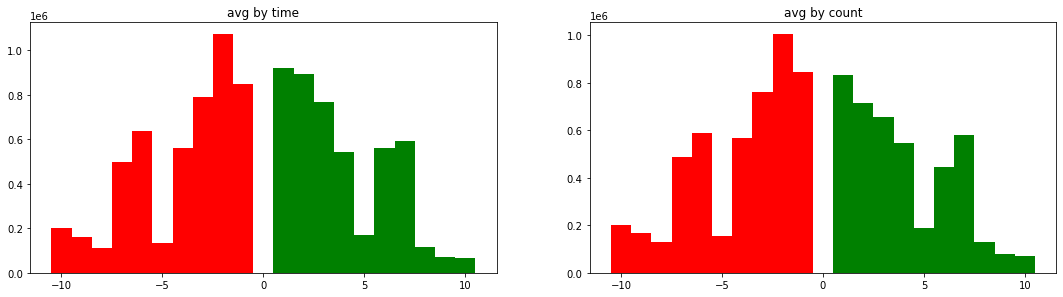

                               ask count            bid time
           bid count     s=0.182 q=1.480     s=0.045 q=1.480
            ask time     s=0.150 q=1.480     s=0.213 q=1.480


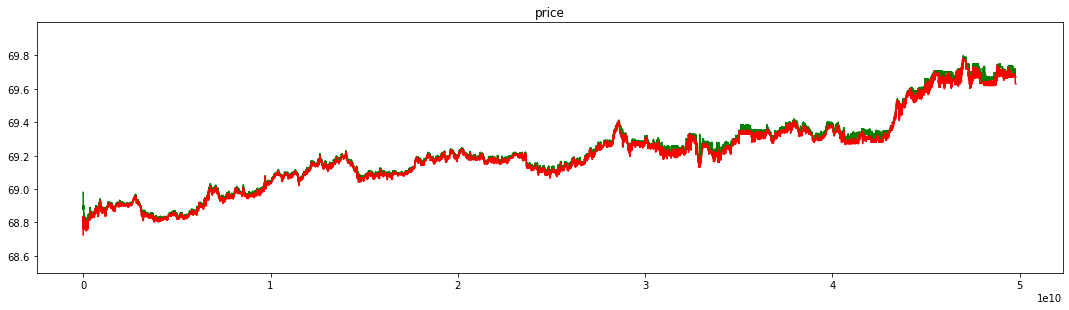

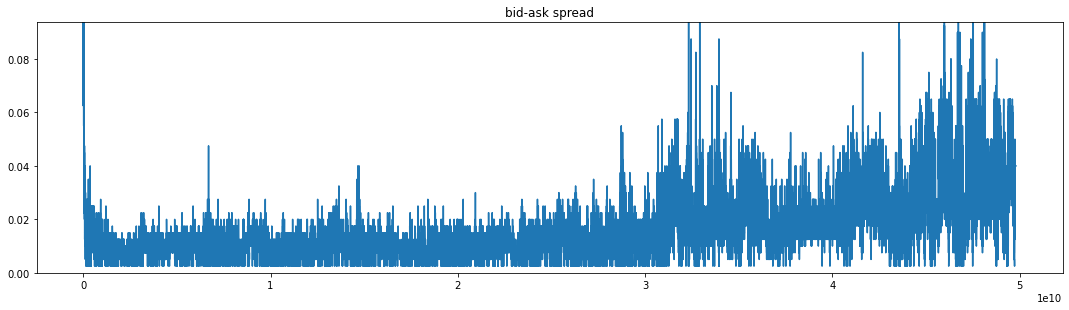

EURUSD000TOD


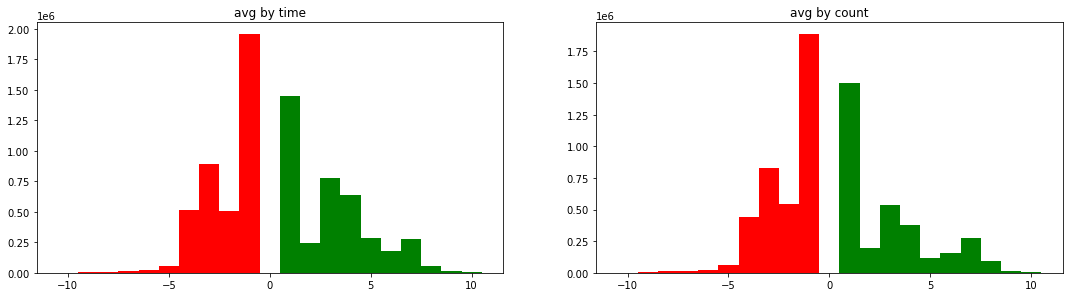

                               ask count            bid time
           bid count     s=0.892 q=1.480     s=0.077 q=1.480
            ask time     s=0.443 q=1.480     s=1.073 q=1.480


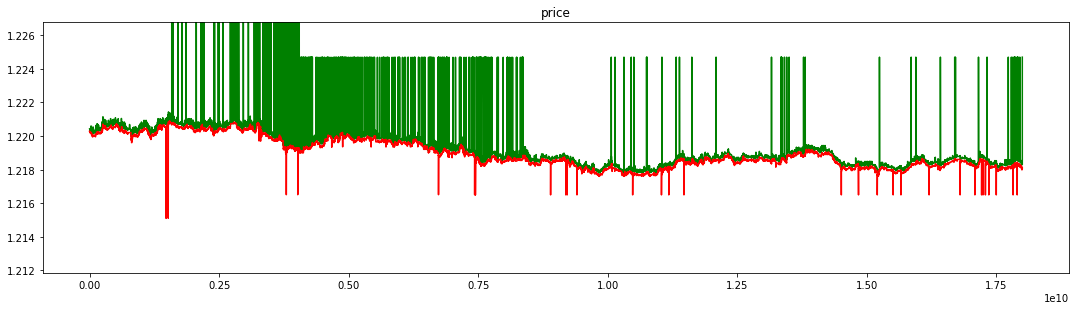

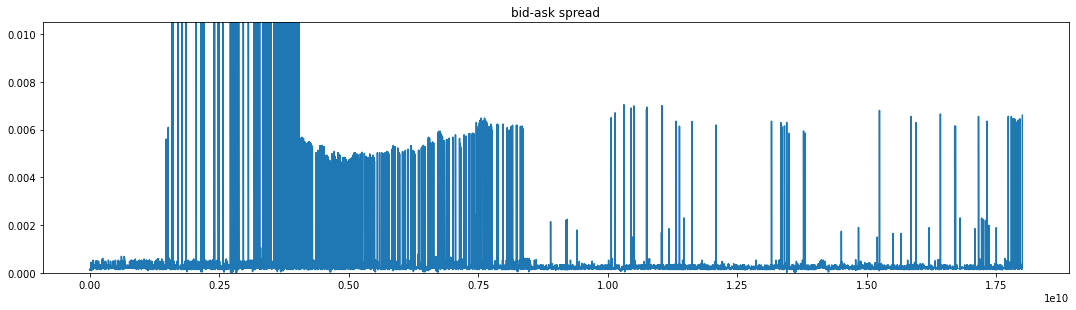

EURUSD000TOM


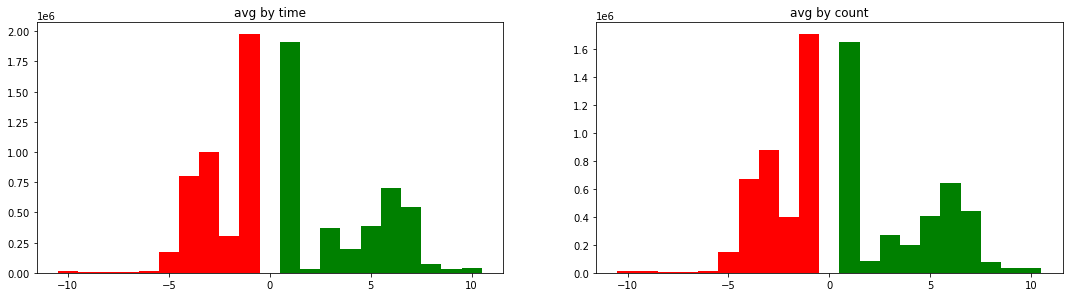

                               ask count            bid time
           bid count     s=1.873 q=1.480     s=0.087 q=1.480
            ask time     s=0.090 q=1.480     s=1.811 q=1.480


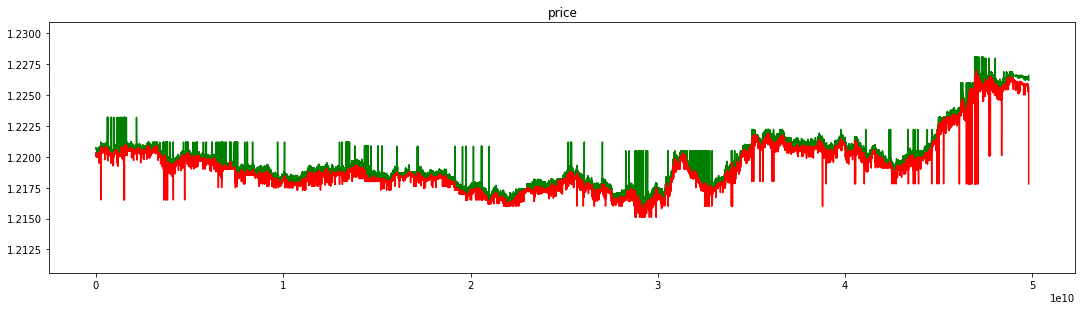

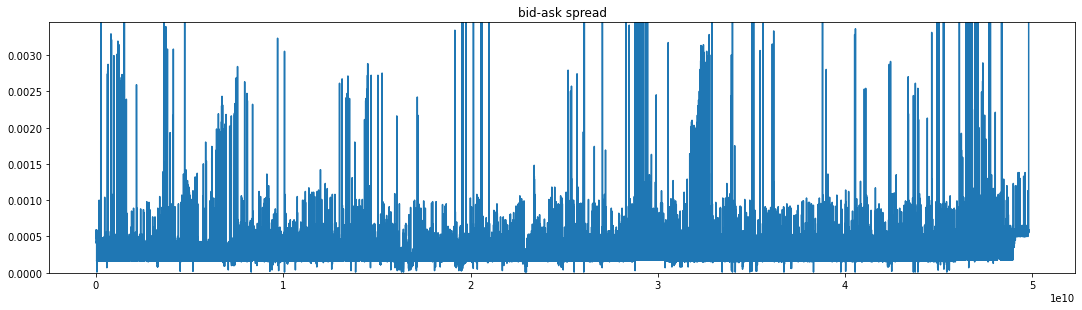

In [9]:
minstep = {'USD000000TOD': 250, 'USD000UTSTOM': 250, 'EUR_RUB__TOD': 250, 'EUR_RUB__TOM': 250, 'EURUSD000TOD':1, 'EURUSD000TOM':1}
instruments = ['USD000000TOD', 'USD000UTSTOM', 'EUR_RUB__TOD', 'EUR_RUB__TOM', 'EURUSD000TOD', 'EURUSD000TOM']
for instrument in  instruments:
    print(instrument)
    task3(pd.read_csv(f'../out2/2018-03/OrderLog20180301/{instrument}_spec.csv').drop([0]), minstep[instrument]/100000)

## same for different time periods

In [10]:
times = [0, 5*60*60*(10**6), 9*60*60*(10**6), 13*60*60*(10**6) + 50*60*(10**6)]
times = [(times[i], times[i+1]) for i in range(len(times)-1)]
times

[(0, 18000000000), (18000000000, 32400000000), (32400000000, 49800000000)]

In [11]:
def task3_w_bt(df,bt, step=None):
    df = df[df['ts'].between(*bt)]
    
    plt.subplots_adjust(hspace=1,right=2.5,bottom=0.01)
    bid_c = [df['bid'+str(i)].mean() for i in range(50)]
    ask_c = [df['ask'+str(i)].mean() for i in range(50)]
    
    bid_c = shorten(bid_c)
    ask_c = shorten(ask_c)
    
    plt.bar(range(1, len(ask_c) + 1), ask_c, color='green', width=1)
    plt.bar(range(-1, -len(bid_c) - 1, -1), bid_c,color='red', width=1)
    plt.title("avg by count")
    plt.show()

    plt.subplots_adjust(hspace=1,right=2.5,bottom=0.01)
    plt.plot(df['ts'], df['sa'], color='green')
    plt.plot(df['ts'], df['lb'], color='red')
    
    
    clean = df[(df['sa']!=float('inf')) & (df['lb']!=0.0)]
    
    s,l = ((clean['sa'] + clean['lb'])/2).quantile([0.05,0.95])
    plt.ylim(bottom=s*0.995)
    plt.ylim(top=l*1.005)
    plt.title('price')
    plt.show()

    plt.subplots_adjust(hspace=1,right=2.5,bottom=0.01)
    plt.plot(df['ts'], df['sa']-df['lb'])
    l = (df['sa']-df['lb']).quantile(0.999)
    plt.ylim(top = l*1.5, bottom=0.0)
    plt.title('bid-ask spread')
    plt.show()

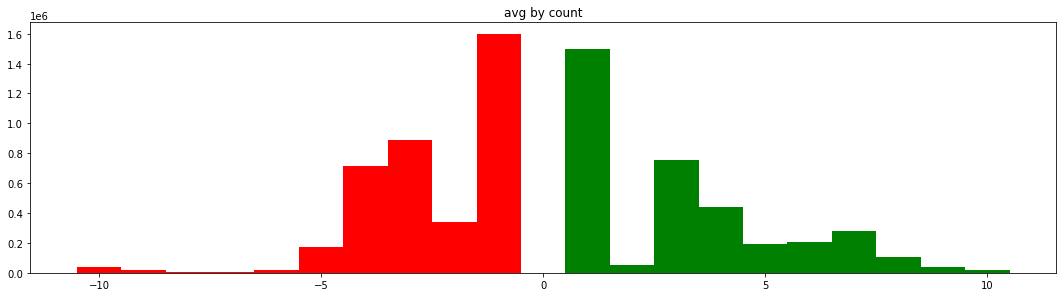

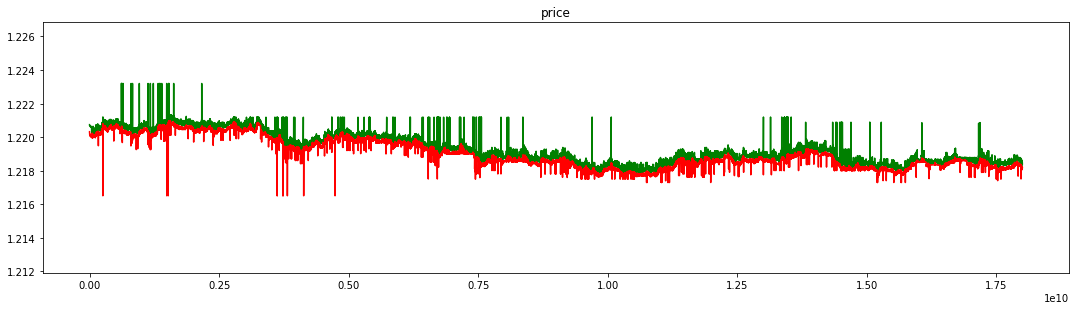

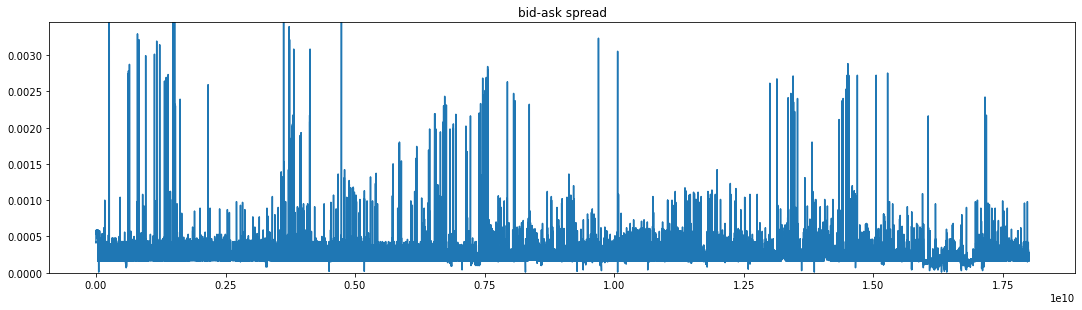

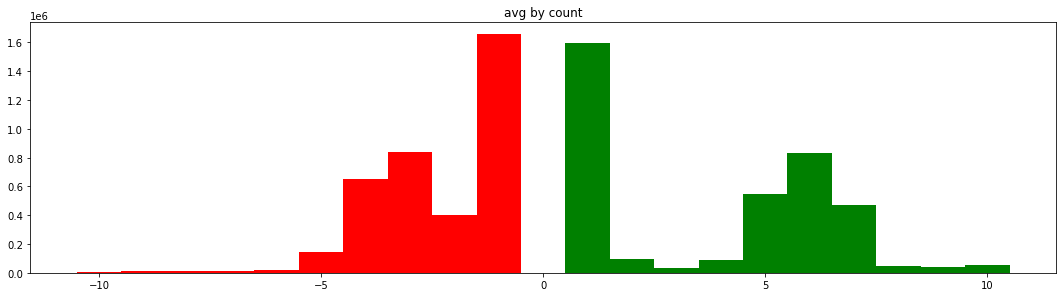

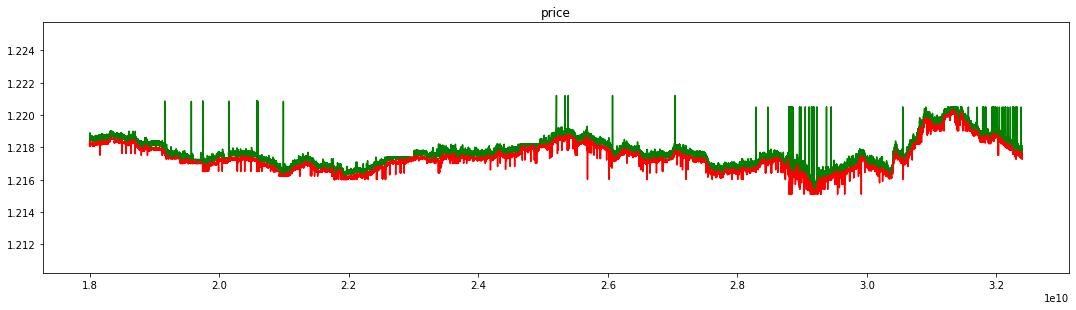

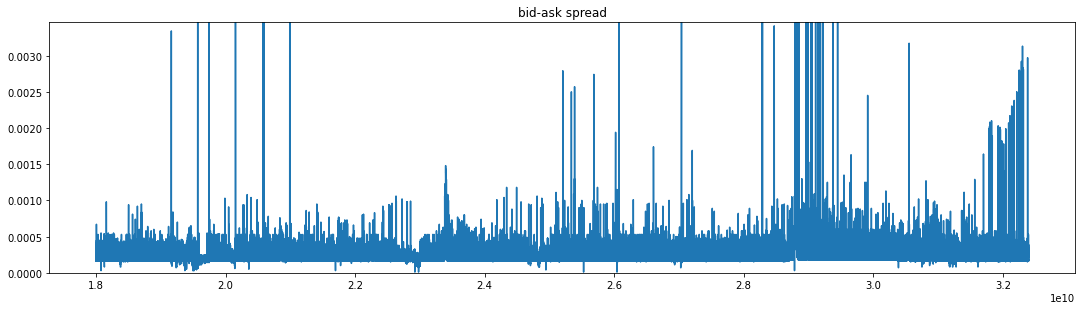

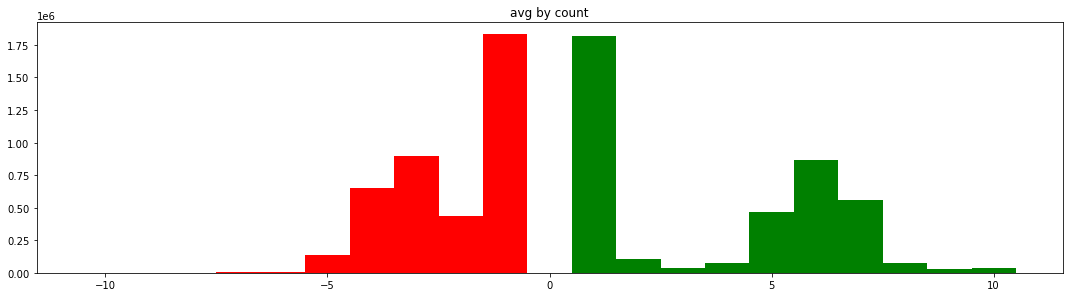

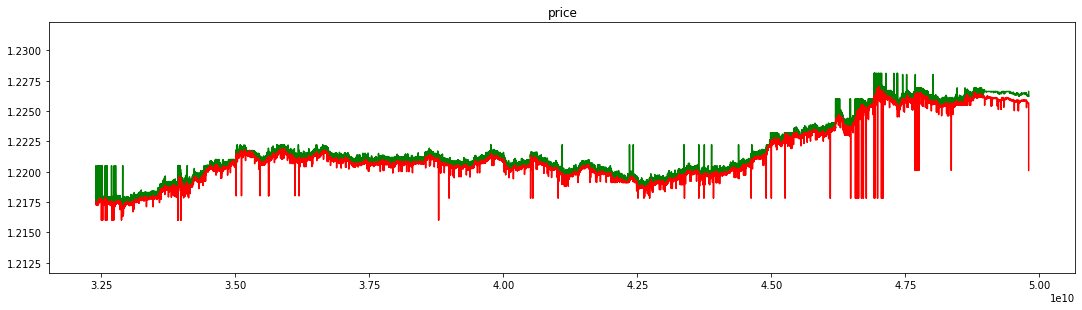

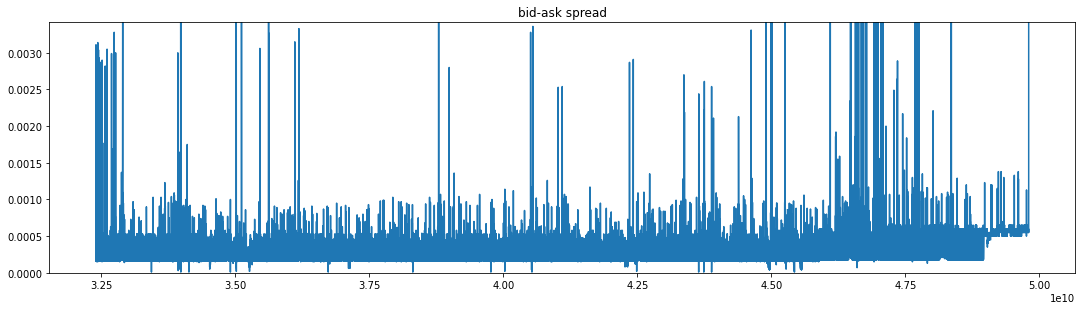

In [12]:
df = pd.read_csv(f'../out2/2018-03/OrderLog20180301/{instrument}_spec.csv').drop([0])
df['ts']=df['ts'].apply(timefix)

minstep = {'USD000000TOD': 250, 'USD000UTSTOM': 250, 'EUR_RUB__TOD': 250, 'EUR_RUB__TOM': 250, 'EURUSD000TOD':1, 'EURUSD000TOM':1}
instrument = 'USD000UTSTOM'

task3_w_bt(df, times[0], minstep[instrument]/100000)
task3_w_bt(df, times[1], minstep[instrument]/100000)
task3_w_bt(df, times[2], minstep[instrument]/100000)

# Part 3 correlation between different periods

In [13]:
day = '2018-03'
#l = [e for e in os.listdir(f'../MOEX-FX/{day}/') if e[:3]=='Ord']
files = [e for e in os.listdir(f'../MOEX-FX/2018-03/') if e[:3]=='Ord']
files.remove('OrderLog20180309.txt')
files.remove('OrderLog20180330.txt')
times = [0, 5*60*60*(10**6), 9*60*60*(10**6), 13*60*60*(10**6) + 50*60*(10**6)]
times = [(times[i], times[i+1]) for i in range(len(times)-1)]
minstep = {'USD000000TOD': 250, 'USD000UTSTOM': 250, 'EUR_RUB__TOD': 250, 'EUR_RUB__TOM': 250, 'EURUSD000TOD':1, 'EURUSD000TOM':1}
instruments = ['USD000000TOD', 'USD000UTSTOM', 'EUR_RUB__TOD', 'EUR_RUB__TOM', 'EURUSD000TOD', 'EURUSD000TOM']
results = {isnt: {f:{'b': [], 'a': []} for f in files} for isnt in instruments}

for instrument in  instruments:
    print(instrument)
    for file in files:
        print(file)
        df = pd.read_csv(f'../out2/2018-03/{file[:-4]}/{instrument}_spec.csv').drop([0])
        df['ts']=df['ts'].apply(timefix)
        for time_range in times:
            df2 = df[df['ts'].between(*time_range)]
            bid_c = [df2['bid'+str(i)].mean() for i in range(50)]
            ask_c = [df2['ask'+str(i)].mean() for i in range(50)]
            bid_c = shorten(bid_c)
            ask_c = shorten(ask_c)
            results[instrument][file]['a'].append(ask_c)
            results[instrument][file]['b'].append(bid_c)

USD000000TOD
OrderLog20180301.txt
OrderLog20180302.txt
OrderLog20180305.txt
OrderLog20180306.txt
OrderLog20180307.txt
OrderLog20180312.txt
OrderLog20180313.txt
OrderLog20180314.txt
OrderLog20180315.txt
OrderLog20180316.txt
OrderLog20180319.txt
OrderLog20180320.txt
OrderLog20180321.txt
OrderLog20180322.txt
OrderLog20180323.txt
OrderLog20180326.txt
OrderLog20180327.txt
OrderLog20180328.txt
OrderLog20180329.txt
USD000UTSTOM
OrderLog20180301.txt
OrderLog20180302.txt
OrderLog20180305.txt
OrderLog20180306.txt
OrderLog20180307.txt
OrderLog20180312.txt
OrderLog20180313.txt
OrderLog20180314.txt
OrderLog20180315.txt
OrderLog20180316.txt
OrderLog20180319.txt
OrderLog20180320.txt
OrderLog20180321.txt
OrderLog20180322.txt
OrderLog20180323.txt
OrderLog20180326.txt
OrderLog20180327.txt
OrderLog20180328.txt
OrderLog20180329.txt
EUR_RUB__TOD
OrderLog20180301.txt
OrderLog20180302.txt
OrderLog20180305.txt
OrderLog20180306.txt
OrderLog20180307.txt
OrderLog20180312.txt
OrderLog20180313.txt
OrderLog20180314

In [17]:
def pretty(x):
    for e in x:
        print('|', e, ' '*(20-len(str(e))), end='')
    print('|')
    
def my_ks(data1, data2, n = None, m= None, as_bool=False):
    n = n if n is not None else len(data1)
    m = m if m is not None else len(data2)
    data1 = [sum(data1[0:i+1]) for i in range(len(data1))]
    data2 = [sum(data2[0:i+1]) for i in range(len(data2))]
    data1 = [e/data1[-1] for e in data1]
    data2 = [e/data2[-1] for e in data2]
    d = max(abs(a - b) for a,b in zip(data1,data2))
    a = 0.975
    ka = np.sqrt(-1/2*np.log((1-a)/2))
    if (as_bool): 
        return d*np.sqrt((n*m)/(n+m)) <= ka
    else: 
        return d*np.sqrt((n*m)/(n+m)), ka

In [18]:
print('time vs time')
n = 10

for instrument in  instruments:
    print(instrument)
    pretty(['', '10:00 vs 15:00', '15:00 vs 19:00', '10:00 vs 19:00'])
    for file in files:
        l = [file[:-4]]
        for i,a,b in [(0,0,1),(1,1,2),(2,2,0)]:
            ask = my_ks(results[instrument][file]['a'][a], results[instrument][file]['a'][b], n, n, as_bool=True)
            
            if (pd.isna(results[instrument][file]['a'][a][0]) or pd.isna(results[instrument][file]['a'][b][0])):
                ask='nan'
            #else:
            #    ask = my_ks(results[instrument][file]['a'][a], results[instrument][file]['a'][b])[0]
            
            bid = my_ks(results[instrument][file]['b'][a], results[instrument][file]['b'][b], n, n , as_bool=True)
            
            
            if (pd.isna(results[instrument][file]['b'][a][0]) or pd.isna(results[instrument][file]['b'][b][0])):
                bid='nan'
            #else:
            #    bid = my_ks(results[instrument][file]['b'][a], results[instrument][file]['b'][b])[0]
            
            l.append((ask,bid))
        pretty(l)

time vs time
USD000000TOD
|                      | 10:00 vs 15:00       | 15:00 vs 19:00       | 10:00 vs 19:00       |
| OrderLog20180301     | (True, True)         | ('nan', 'nan')       | ('nan', 'nan')       |
| OrderLog20180302     | (True, True)         | ('nan', 'nan')       | ('nan', 'nan')       |
| OrderLog20180305     | (True, True)         | ('nan', 'nan')       | ('nan', 'nan')       |
| OrderLog20180306     | (True, True)         | ('nan', 'nan')       | ('nan', 'nan')       |
| OrderLog20180307     | (True, True)         | ('nan', 'nan')       | ('nan', 'nan')       |
| OrderLog20180312     | (True, True)         | ('nan', 'nan')       | ('nan', 'nan')       |
| OrderLog20180313     | (True, True)         | ('nan', 'nan')       | ('nan', 'nan')       |
| OrderLog20180314     | (True, True)         | ('nan', 'nan')       | ('nan', 'nan')       |
| OrderLog20180315     | (True, True)         | ('nan', 'nan')       | ('nan', 'nan')       |
| OrderLog20180316     | (True, Tr

In [19]:
print('today vs yesterday')
n = 10

for instrument in  instruments:
    print(instrument)
    pretty(['', '10:00 - 15:00', '15:00 - 19:00', '10:00 - 19:00'])
    last = None
    for file in files:
        l = [file[:-4]]
        if (last is None):
            pretty(l + 3*['- -'])
        else:
            for i in range(3):
                ask = my_ks(results[instrument][file]['a'][i], results[instrument][last]['a'][i], n, n, as_bool=True)

                if (pd.isna(results[instrument][file]['a'][i][0]) or pd.isna(results[instrument][last]['a'][i][0])):
                    ask='nan'

                bid = my_ks(results[instrument][file]['b'][i], results[instrument][last]['b'][i], n, n, as_bool=True)
                
                if (pd.isna(results[instrument][file]['b'][i][0]) or pd.isna(results[instrument][last]['b'][i][0])):
                    bid='nan'

                l.append((ask,bid))
            pretty(l)
        last = file

today vs yesterday
USD000000TOD
|                      | 10:00 - 15:00        | 15:00 - 19:00        | 10:00 - 19:00        |
| OrderLog20180301     | - -                  | - -                  | - -                  |
| OrderLog20180302     | (True, True)         | (True, True)         | ('nan', 'nan')       |
| OrderLog20180305     | (True, True)         | (True, True)         | ('nan', 'nan')       |
| OrderLog20180306     | (True, True)         | (True, True)         | ('nan', 'nan')       |
| OrderLog20180307     | (True, True)         | (True, True)         | ('nan', 'nan')       |
| OrderLog20180312     | (True, True)         | (True, True)         | ('nan', 'nan')       |
| OrderLog20180313     | (True, True)         | (True, True)         | ('nan', 'nan')       |
| OrderLog20180314     | (True, True)         | (True, True)         | ('nan', 'nan')       |
| OrderLog20180315     | (True, True)         | (True, True)         | ('nan', 'nan')       |
| OrderLog20180316     | (Tr

# Part 4 generating features

Calculating VWAP

SA = price of smallest ask 
<br>
$ \Delta p = $ price step  
$bas = $ bid-ask spread 
$$ \frac{v_1(SA+\Delta p*0)+v_2(SA+\Delta p*1)+v_3(SA+\Delta p*2)}{v_1+v_2+v_3} - SA + bas/2 = \frac{v_1(\Delta p*0+bas/2)+v_2(\Delta p*1+bas/2)+v_3(\Delta p*2+bas/2)}{v_1+v_2+v_3} $$

In [ ]:
def get_VWAP(l, v, bas, dp): 
    c = 0 
    s = 0 
    for i,e in enumerate(l):
        if s+e>=v:
            c+=(v-s)*(dp*i + bas/2) 
            return c/v
        s += e 
        c += e*(dp*i + bas/2) 
    return c/s

In [ ]:
def timefix(t):
    # transform HHMMSSZZZXXX format into microseconds since the begining of the trading day
    t=str(t-100000000000)
    t='0'*(12-len(t))+t
    h=int(t[0:2])*60*60*(10**6)
    m=int(t[2:4])*60*(10**6)
    s=int(t[4:6])*10**6
    z=int(t[6:9])*10**3
    x=int(t[9:12])*1
    return h+m+s+z+x

def my_ks(data1, data2, n, m):
    data1 = [sum(data1[0:i+1]) for i in range(len(data1))]
    data2 = [sum(data2[0:i+1]) for i in range(len(data2))]
    data1 = [e/data1[-1] for e in data1]
    data2 = [e/data2[-1] for e in data2]
    d = max(abs(a - b) for a,b in zip(data1,data2))
    a = 0.975
    ka = np.sqrt(-1/2*np.log((1-a)/2))
    return d*np.sqrt((n*m)/(n+m)), ka

def shorten(l):
    # 50 elements spectrum -> 10 elements spectrum
    return [sum(l[i:i+5]) for i in range(0,50,5)]

In [ ]:
#days=['2018-03','2018-04','2018-05']
days=['2018-04','2018-05']
#l = [e for e in os.listdir(f'../MOEX-FX/{day}/') if e[:3]=='Ord']
minstep = {'USD000000TOD': 250, 'USD000UTSTOM': 250, 'EUR_RUB__TOD': 250, 'EUR_RUB__TOM': 250, 'EURUSD000TOD':1, 'EURUSD000TOM':1}
instruments = ['USD000000TOD', 'USD000UTSTOM', 'EUR_RUB__TOD', 'EUR_RUB__TOM']
# /100000
out = 'out2'
#delite_old = True

for day in days:
    # Цикл по файлам
    l = [e for e in os.listdir(f'../MOEX-FX/{day}/') if e[:3]=='Ord']
    for file in l:
        print('startng', file)
        try:
            for instrument in instruments:
                print('starting', instrument)
                path_out = f'../{out}/{day}/{file[:-4]}/'
                path_out2 = f'../out3/{day}/{file[:-4]}/'
                if (os.path.exists(os.path.join(path_out2, instrument+'_features'+'.csv'))):
                    print('Already exists!')
                    continue
                # чтение промежуточных файлов
                spec = pd.read_csv(f'../{out}/{day}/{file[:-4]}/{instrument}_spec.csv').drop([0])
                log = pd.read_csv(f'../{out}/{day}/{file[:-4]}/{instrument}_syslog.csv').drop([0])
                spec['ts'] = spec['ts'].apply(timefix)
                log['ts'] = log['ts'].apply(timefix)
                print('alpplyed')

                # финальный файл
                data = {'ts': [], 'sa': [], 'lb': [], 'bas': []}
                data.update({'ask'+str(i):[] for i in range(10)})
                data.update({'bid'+str(i):[] for i in range(10)})
                data.update({'VWAP_ask_'+str(i):[] for i in ['100k', '200k', '500k', '5m', '10m']})
                data.update({'VWAP_bid_'+str(i):[] for i in ['100k', '200k', '500k', '5m', '10m']})

                data.update({'agro_ask_'+str(i):[] for i in ['1s', '5s', '15s', '30s', '60s']})
                data.update({'agro_bid_'+str(i):[] for i in ['1s', '5s', '15s', '30s', '60s']})
                data.update({'passive_ask_'+str(i):[] for i in ['1s', '5s', '15s', '30s', '60s']})
                data.update({'passive_bid_'+str(i):[] for i in ['1s', '5s', '15s', '30s', '60s']})

                time_spec = 0.0
                time_VWAP = 0.0
                time_traverse = 0.0
                time_tail = 0.0

                # для динамики
                tail = {}
                tail.update({f'agro_ask_{i}': deque() for i in ['1s', '5s', '15s', '30s', '60s']})
                tail.update({f'agro_bid_{i}': deque() for i in ['1s', '5s', '15s', '30s', '60s']})
                tail.update({f'passive_ask_{i}': deque() for i in ['1s', '5s', '15s', '30s', '60s']})
                tail.update({f'passive_bid_{i}': deque() for i in ['1s', '5s', '15s', '30s', '60s']})

                log_it = log.iterrows()
                log_event = next(log_it)[1]
                ii = 0
                percent = 0.0

                df = spec
                ll = len(df)
                print('len= ', ll)

                # Цикл по спектру
                for _, e in df.iterrows():
                    if (ii/ll >= percent):
                        print(int((ii/ll)*100),'%')
                        percent += 0.1
                    ii+=1

                    t = time.time()
                    # BAS and timestamp
                    data['ts'].append(e['ts'])
                    data['bas'].append((e['sa']-e['lb'])/(minstep[instrument]/100000))
                    data['sa'].append(e['sa'])
                    data['lb'].append(e['lb'])
                    # Spectrum
                    ask = [e['ask'+str(i)] for i in range(50)]
                    bid = [e['ask'+str(i)] for i in range(50)]
                    ask_short = shorten(ask)
                    bid_short = shorten(bid)
                    for i in range(10):
                        data['ask'+str(i)].append(ask_short[i]/10**6)
                    for i in range(10):
                        data['bid'+str(i)].append(bid_short[i]/10**6)

                    time_spec += time.time() - t
                    t = time.time()

                    # VWAP
                    for side, s in [('ask', ask), ('bid',bid)]:
                        ms = minstep[instrument]/100000
                        volumes = [('100k', 100*1000), ('200k', 200*1000), ('500k', 500*1000), ('5m', 5*10**6), ('10m',10*10**6)]
                        for v_name, vol in volumes:
                            data[f'VWAP_{side}_{v_name}'].append(get_VWAP(s, vol, abs(e['sa']-e['lb']), ms)/ms)

                    time_VWAP += time.time() - t
                    t = time.time()

                    # calculate dinamic on this step
                    gain_agro = {'ask':0, 'bid':0}
                    gain_passive = {'ask':0, 'bid':0}

                    try:
                        while (log_event is not None and log_event['ts']<=e['ts']):
                            if (log_event['type']=='agro'):
                                if (log_event['side']=='a'):
                                    gain_agro['ask'] += log_event['vol']
                                if (log_event['side']=='b'):
                                    gain_agro['bid'] += log_event['vol']
                            if (log_event['type']=='passive'):
                                if (log_event['price_norm'] <= 5):
                                    if (log_event['side']=='a'):
                                        gain_passive['ask']+=log_event['vol']
                                    if (log_event['side']=='b'):
                                        gain_passive['bid']+=log_event['vol']
                            log_event = next(log_it)[1]
                    except StopIteration:
                        print('iter done')
                        log_event = None

                    time_traverse += time.time() - t
                    t = time.time()


                    # calculate dinamic
                    for side in ['ask','bid']:
                        ts = [('1s', 10**6), ('5s', 5*10**6), ('15s', 15*10**6), ('30s', 30*10**6), ('60s', 60*10**6)]
                        for t_name, t_val in ts:
                            my_tail = tail[f'agro_{side}_{t_name}']
                            if (gain_agro[side]!=0):
                                my_tail.append({'ts':e['ts'], 'gain': gain_agro[side]})
                            while (my_tail and e['ts'] - my_tail[0]['ts'] > t_val): my_tail.popleft()

                            data[f'agro_{side}_{t_name}'].append(sum(x['gain'] for x in my_tail)/t_val)

                    for side in ['ask','bid']:
                        ts = [('1s', 10**6), ('5s', 5*10**6), ('15s', 15*10**6), ('30s', 30*10**6), ('60s', 60*10**6)]
                        for t_name, t_val in ts:
                            my_tail = tail[f'passive_{side}_{t_name}']
                            if (gain_passive[side]!=0):
                                my_tail.append({'ts':e['ts'], 'gain': gain_passive[side]})
                            while (my_tail and e['ts'] - my_tail[0]['ts'] > t_val): my_tail.popleft()

                            data[f'passive_{side}_{t_name}'].append(sum(x['gain'] for x in my_tail)/t_val)

                    time_tail += time.time() - t

                print('100% done, saving')
                
                
                if not os.path.exists(path_out2):
                    os.makedirs(path_out2
                               )
                
                pd.DataFrame(data=data).to_csv(os.path.join(path_out, instrument+'_features'+'.csv'), index=False)

                print('time_spec= ', time_spec)
                print('time_VWAP= ', time_VWAP)
                print('time_traverse= ', time_traverse)
                print('time_tail= ', time_tail)
        except FileNotFoundError as e:
            print('FileNotFoundError')
            print(repr(e))


# features file example

In [20]:
pd.read_csv('../out3/2018-03/OrderLog20180301/USD000000TOD_features.csv')

,ts,sa,lb,bas,ask0,ask1,ask2,ask3,ask4,ask5,...,passive_ask_1s,passive_ask_5s,passive_ask_15s,passive_ask_30s,passive_ask_60s,passive_bid_1s,passive_bid_5s,passive_bid_15s,passive_bid_30s,passive_bid_60s
0,5.031600e+04,56.6000,-inf,inf,1.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.00,0.000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000
1,5.036100e+04,56.6000,56.2100,156.0,1.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.00,0.000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000
2,6.172700e+04,56.6000,56.2100,156.0,1.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.00,0.000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000
3,6.177000e+04,56.6000,56.2100,156.0,1.000,0.404,0.000,0.000,0.000,0.000,...,0.0,0.00,0.000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000
4,6.238500e+04,56.6000,56.2100,156.0,1.000,0.404,0.000,0.000,0.000,0.000,...,0.0,0.00,0.000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623760,2.790000e+10,56.9475,56.9425,2.0,0.874,1.040,0.158,11.479,0.147,0.024,...,0.2,0.04,0.019,0.012833,0.00975,0.0,0.0,0.027933,0.027867,0.036967
623761,2.790000e+10,56.9475,56.9425,2.0,0.874,1.040,0.158,10.479,0.147,0.024,...,0.2,0.04,0.019,0.012833,0.00975,0.0,0.0,0.027933,0.027867,0.036967
623762,2.790000e+10,56.9475,56.9425,2.0,0.874,1.040,0.158,10.479,0.147,0.024,...,0.2,0.04,0.019,0.012833,0.00975,0.0,0.0,0.027933,0.027867,0.036967
623763,2.790000e+10,56.9475,56.9425,2.0,0.874,0.040,0.158,10.479,0.147,0.024,...,0.2,0.04,0.019,0.012833,0.00975,0.0,0.0,0.027933,0.027867,0.036967


# Lead-lag analysis

## function for calculateing covariance and correlataion

In [31]:
def super_cov(time1, val1, time2, val2):
    assert len(time1) == len(val1)
    assert len(time2) == len(val2)
    i = 0
    j = 0
    res = 0
    while(i < len(time1) - 1 and j < len(time2) - 1):
        l = min(time1[i+1], time2[j+1]) - max(time1[i], time2[j])
        if (l>0):
            res += val1[i]*val2[j]*l
        
        if (time1[i+1] > time2[j+1]):
            j+=1
        else:
            i+=1    
    return res

## Reading dataset with smallest ask and largest bid for day 1

In [32]:
def clear(df):
    return df[((df.sa != float('inf')) & (df.sa != float('-inf')) & (df.lb != float('inf')) & (df.lb != float('-inf')))]
def super_corr(time1, val1, time2, val2):
    cov = super_cov(time1, val1, time2, val2)
    var1 = np.sqrt(super_cov(time1, val1, time1, val1))
    var2 = np.sqrt(super_cov(time2, val2, time2, val2))
    return cov/(var1*var2)

In [33]:
df_tod = pd.read_csv('../out3/2018-03/OrderLog20180301/EUR_RUB__TOM_features.csv')
df_tod = clear(df_tod)
df_tom = pd.read_csv('../out3/2018-03/OrderLog20180301/USD000UTSTOM_features.csv')
df_tom = clear(df_tom)

In [34]:
time1 = list(df_tod['ts'])
val1 = list((df_tod['sa'] + df_tod['lb'])/2)
time2 = list(df_tom['ts'])
val2 = list((df_tom['sa'] + df_tom['lb'])/2)

## Calculate 1st differance

In [35]:
val3 = [val1[i+1] - val1[i] for i in range(len(val1)-1)]
time3 = time1[:-1]
val4 = [val2[i+1] - val2[i] for i in range(len(val2)-1)]
time4 = time2[:-1]

In [36]:
super_corr(time3, val3, time4, val4)

0.013924090709569778

## For some reason tau differes if we take value from the begginig of interval or the end;

### 1st I'll take time from the begginig of an interval
##### aka `new_time = time[:-1]`
##### interval x<sub>2</sub>-x<sub>1</sub> assosiated with t<sub>1</sub>

In [37]:
x = []
y = []
for k in range(-5000, 5000, 100):
    x.append(k) # EUR_RUB+k vs USD_UTS
    y.append(super_corr([t+k for t in time3], val3, time4, val4))
    print(k, y[-1])

-5000 0.014277101285868786
-4900 0.014272912759345262
-4800 0.014268798811293046
-4700 0.01426624917293596
-4600 0.014264796100707041
-4500 0.014262474767008251
-4400 0.014258906344717447
-4300 0.014253880806153871
-4200 0.01424872685606754
-4100 0.014243715340357371
-4000 0.01423657749789477
-3900 0.014227688216798035
-3800 0.014219835471412198
-3700 0.014211855680024872
-3600 0.014203342547527701
-3500 0.014196396508288415
-3400 0.014187813734204698
-3300 0.014177247750505396
-3200 0.014168026280091174
-3100 0.014160028684406812
-3000 0.014153018518186289
-2900 0.01414490784683388
-2800 0.01413621929736903
-2700 0.014126968678326971
-2600 0.014119536618543219
-2500 0.014111317020606577
-2400 0.0141025736927294
-2300 0.014098866407425872
-2200 0.014102067767085837
-2100 0.014104506115456486
-2000 0.014109251984752753
-1900 0.014110651539050525
-1800 0.014106351512460506
-1700 0.014102768437075629
-1600 0.014093370971973258
-1500 0.014083340902866202
-1400 0.014073049126348927
-1300 0.

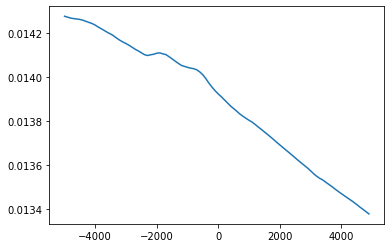

In [38]:
plt.plot(x,y)

-6000 0.01427626091254567
-5900 0.014278154575475674
-5800 0.014279195627910728
-5700 0.014280370974114182
-5600 0.014282281180859962
-5500 0.014283110367412536
-5400 0.014282801076836861
-5300 0.014282202033144268
-5200 0.014281864644341738
-5100 0.014279759063009153
-5000 0.014277101285868786
-4900 0.014272912759345262
-4800 0.014268798811293046
-4700 0.01426624917293596
-4600 0.014264796100707041
-4500 0.014262474767008251
-4400 0.014258906344717447
-4300 0.014253880806153871
-4200 0.01424872685606754
-4100 0.014243715340357371


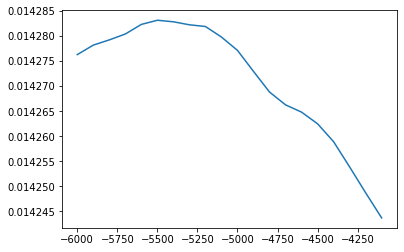

In [39]:
x = []
y = []
for k in range(-6000, -4000, 100):
    x.append(k) # EUR_RUB+k vs USD_UTS
    y.append(super_corr([t+k for t in time3], val3, time4, val4))
    print(k, y[-1])
plt.plot(x,y)

In [40]:
i = y.index(max(y))
print(x[i])

-5500


### tau = -5500

### EUR_RUB__TOM is leading

### USD000UTSTOM is lagging

### now I'll take time from the end of an interval
##### aka `new_time = time[1:]`
##### interval x<sub>2</sub>-x<sub>1</sub> assosiated with t<sub>2</sub>

-5000 0.0040069077512817535
-4900 0.004031098123736156
-4800 0.00403917457336477
-4700 0.004036348948643137
-4600 0.004035815271349548
-4500 0.004031189068742966
-4400 0.004030960207132021
-4300 0.004028387429517628
-4200 0.004028260173134226
-4100 0.00402735971762577
-4000 0.004014942892555215
-3900 0.0039997870570554215
-3800 0.0039936620940595165
-3700 0.003980550022727051
-3600 0.003959255898955615
-3500 0.0039241784430860795
-3400 0.0038943701343777527
-3300 0.0038558834067090094
-3200 0.00381824716476469
-3100 0.003791849793515056
-3000 0.003771701643457622
-2900 0.003757412950276898
-2800 0.0037450774093884093
-2700 0.0037518939541954155
-2600 0.0037783452928117616
-2500 0.0038140966745019815
-2400 0.0038373342897406503
-2300 0.003870210743189041
-2200 0.0039117209759241215
-2100 0.003953901136897273
-2000 0.004007058660028641
-1900 0.004068863953986239
-1800 0.004139350665091316
-1700 0.0042261068716165015
-1600 0.004294073439946428
-1500 0.004355695844494444
-1400 0.0044103198

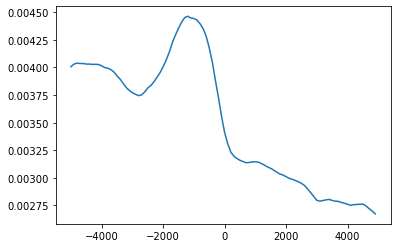

In [42]:
x = []
y = []
for k in range(-5000, 5000, 100):
    x.append(k) # EUR_RUB+k vs USD_UTS
    y.append(super_corr([t+k for t in time1[1:]], val3, time2[1:], val4))
    print(k, y[-1])
plt.plot(x,y)

In [43]:
i = y.index(max(y))
print(x[i])

-1200


### tau = -1200

### EUR_RUB__TOM is leading

### USD000UTSTOM is lagging

### now I have to try average
##### aka `new_time = (time[1:]+time[:-1])/2`
##### interval x<sub>2</sub>-x<sub>1</sub> assosiated with (t<sub>1</sub>+t<sub>2</sub>)/2

-5000 0.011579399735101862
-4900 0.011575701277929186
-4800 0.011573301894673331
-4700 0.011572444912383045
-4600 0.011572338729853507
-4500 0.01156994766644518
-4400 0.011569293893582615
-4300 0.011568309834168514
-4200 0.011568124822032993
-4100 0.011565557598199107
-4000 0.011563763474356604
-3900 0.011560421858865487
-3800 0.011556126348156474
-3700 0.011549602751875174
-3600 0.011544251152386683
-3500 0.01154301833332912
-3400 0.011539684999695363
-3300 0.011535963406508304
-3200 0.011533975836712161
-3100 0.01153112623193304
-3000 0.011526487745955119
-2900 0.011524485587933063
-2800 0.011521118822948356
-2700 0.011518453660452156
-2600 0.011515739908526529
-2500 0.011513071972747849
-2400 0.011509539836546323
-2300 0.011508148902394683
-2200 0.011507979770150837
-2100 0.011501948868404567
-2000 0.011501551491210004
-1900 0.011506912170349416
-1800 0.011507490456741038
-1700 0.011511133942135442
-1600 0.011510808670286523
-1500 0.01150871271453096
-1400 0.011510694471830762
-1300

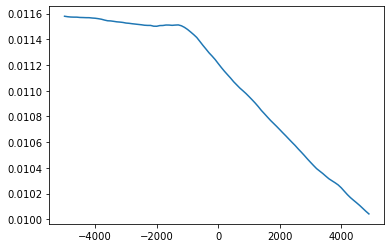

In [44]:
x = []
y = []
for k in range(-5000, 5000, 100):
    x.append(k) # EUR_RUB+k vs USD_UTS
    y.append(super_corr([(t1+t2)/2+k for t1,t2 in zip(time1[1:],time1[:-1])], val3, [(t1+t2)/2 for t1,t2 in zip(time2[1:],time2[:-1])], val4))
    print(k, y[-1])
plt.plot(x,y)

-6000 0.011505603902811457
-5900 0.011517595272525844
-5800 0.011527602985431835
-5700 0.011536155864717589
-5600 0.011543876455324675
-5500 0.01155358951645995
-5400 0.011563112664727645
-5300 0.011570225564550311
-5200 0.011575635516942257
-5100 0.011579807445623142
-5000 0.011579399735101862
-4900 0.011575701277929186
-4800 0.011573301894673331
-4700 0.011572444912383045
-4600 0.011572338729853507
-4500 0.01156994766644518
-4400 0.011569293893582615
-4300 0.011568309834168514
-4200 0.011568124822032993
-4100 0.011565557598199107


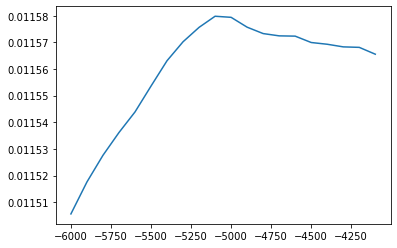

In [45]:
x = []
y = []
for k in range(-6000, -4000, 100):
    x.append(k) # EUR_RUB+k vs USD_UTS
    y.append(super_corr([(t1+t2)/2+k for t1,t2 in zip(time1[1:],time1[:-1])], val3, [(t1+t2)/2 for t1,t2 in zip(time2[1:],time2[:-1])], val4))
    print(k, y[-1])
plt.plot(x,y)

In [46]:
i = y.index(max(y))
print(x[i])

-5100


### tau = -5100

### EUR_RUB__TOM is leading

### USD000UTSTOM is lagging

## I have different tau depending on how we assosiate time and interval
## But EUR_RUB__TOM is leading anyway
### tau changes from -800 to -5500

# Unit-root test and Frational order differentiation

In [47]:
def urt(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

Compare urt of $x$ and $\Delta x$

In [48]:
urt(val1)

0.9999862864333023

In [49]:
urt(val3)

-0.21215590499388431

In [51]:
def gen_coef(a):
    k=1
    x=1
    while (True):
        yield x
        x = -x*(a-k+1)/k
        k+=1

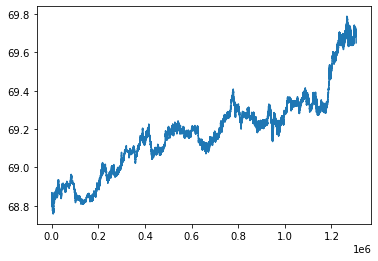

In [54]:
plt.plot(val1)

0.7
0.8799604257516482


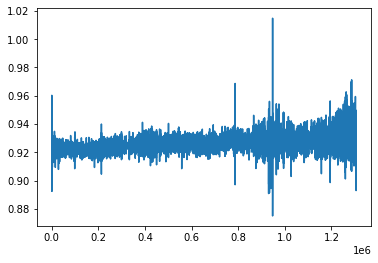

0.7999999999999999
0.5113312160286745


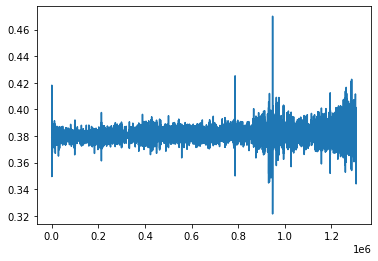

0.8999999999999999
-0.04096738298472047


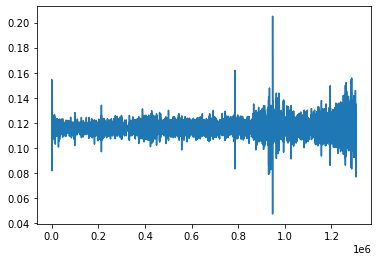

0.9999999999999999
-0.2126298609458688


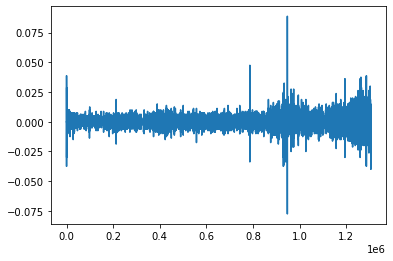

In [52]:
x = []
y = []
for a in np.arange(0.7, 1.001, 0.1):
    val100 = []
    print(a)
    for i in range(len(val1)):
        s = 0
        coef = gen_coef(a)
        for j in range(i,max(0,i-100),-1):
            c = next(coef)
            s += c*val1[j]
        val100.append(s)
    plt.plot(val100[100:])
    print(urt(val100[100:]))
    
    x.append(a)
    y.append(urt(val100[100:]))
    plt.show()

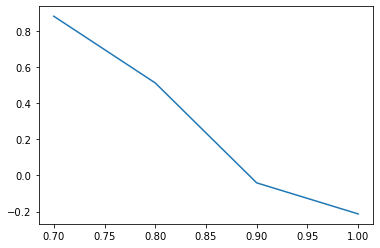

In [53]:
plt.plot(x,y)